In [1]:
from netgen.geom2d import SplineGeometry
from ngsolve import Mesh
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy import dot, exp, sqrt, pi, sin, cos, conj, dot 
from numpy import trapz as Int


from labels import EdgeType
from checking_tools import checkLabels, checkNormals
from Trefft_tools import TrefftzSpace, TrefftzFunction, AssembleMatrix, AssembleRHS, Sigma_broken, TestFunction

In [2]:
R = 10.
H = 1.

def createMesh( h_max = 2.):
    '''Creates a netgen mesh and returns the NG-solve wrapper.'''
    geo = SplineGeometry()
    geo.AddRectangle(p1=(-R,-H),
                    p2=( R, H),
                    bcs=["Gamma","Sigma_R","Gamma","Sigma_L"], #consider defining gamma_T and gamma_D
                    leftdomain=1,
                    rightdomain=0)
    geo.AddCircle(c=(0,0),
                r=0.2,
                bc="dOmega",
                leftdomain=2,
                rightdomain=1)
    geo.SetMaterial (1, "Omega_e")
    geo.SetMaterial (2, "Omega_i")

    Omega = Mesh(geo.GenerateMesh(maxh= h_max))
    
    return Omega

def testMesh( h_max = 2):
    '''Creates a simple mesh without scatterer for testing.'''
    geo = SplineGeometry()
    geo.AddRectangle(p1=(-R,-H),
                    p2=( R, H),
                    bcs=["Gamma","Sigma_R","Gamma","Sigma_L"],
                    leftdomain=1,
                    rightdomain=0)
    geo.SetMaterial (1, "Omega_e")

    Omega = Mesh(geo.GenerateMesh(maxh= h_max))
    
    return Omega



# Omega = createMesh()
Omega = testMesh(0.6)

In [3]:


def computeEdgeType(Omega, edge):
        
    if edge.nr in [ e.edges[0].nr for e in Omega.Boundaries("Gamma").Elements()]:
        return EdgeType.GAMMA

    elif edge.nr in [ e.edges[0].nr for e in Omega.Boundaries("Sigma_L").Elements()]:
        return EdgeType.SIGMA_L

    elif edge.nr in [ e.edges[0].nr for e in Omega.Boundaries("Sigma_R").Elements()]:
        return EdgeType.SIGMA_R

    else:
        return EdgeType.INNER




class Edge:
    '''Holds all the information from an edge that is needed:
    - P : inital vertex
    - Q : end point
    - N : normal
    - T : tangent
    - Type: EdgeType: {INNER, GAMMA, SIGMA_L, SIGMA_R}
    - Triangles: tuple of one or two element IDs.'''

    def __init__(self, Omega, edge ):
        P = np.array( Omega.vertices[edge.vertices[0].nr].point)
        Q = np.array( Omega.vertices[edge.vertices[1].nr].point)        
        self.P = P
        self.Q = Q
        self.Type = computeEdgeType(Omega,edge)

        if self.Type == EdgeType.SIGMA_L:
            if self.P[1] < self.Q[1]:
                self.P, self.Q = self.Q, self.P

        if self.Type == EdgeType.SIGMA_R:
            if self.P[1] > self.Q[1]:
                self.P, self.Q = self.Q, self.P


        self.N = self.getNormal()
        self.T = self.getTangent() 
        self.midpoint = (P+Q)/2 #not needed right now
        self.Triangles = self.setTriangles(Omega,edge)
    
    def __repr__(self):
        return f'''Edgetype: {self.Type}
        (Px, Py): ({self.P[0]}, {self.P[1]}) 
        (Qx, Qy): ({self.Q[0]}, {self.Q[1]})'''


#        probably they should be properties with getters and setters, fix later    

    def getNormal(self):
        px, py = self.P 
        qx, qy = self.Q 
        tx, ty = self.Q - self.P

        match self.Type: #maybe use gamma_up and gamma_down
            
            case EdgeType.GAMMA:
                return np.array([0., py / np.abs(py)])
            
            case EdgeType.SIGMA_L:

                return np.array([-1., 0.])

            case EdgeType.SIGMA_R:
                return np.array([1., 0.])

            case EdgeType.INNER:
                return np.array([ -ty, tx] ) / norm([tx,ty])


    def getTangent(self):
        T = (self.Q - self.P) / norm(self.Q - self.P)
        return T

    def setTriangles(self, Omega, edge):
        Triangles = [ K.nr for K in edge.faces ]
        if len(Triangles) == 1:
            return Triangles
        else:  # put first K^+
            B_1 = 1/3*(sum([ np.array(Omega.vertices[v.nr].point) for v in Omega.faces[Triangles[0]].vertices ]))          
            B_2 = 1/3*(sum([ np.array(Omega.vertices[v.nr].point) for v in Omega.faces[Triangles[1]].vertices ]))          
            if dot(self.N, B_2 - B_1) > 0:
                return Triangles
            else:
                return [Triangles[1], Triangles[0]]




Edges = [ Edge(Omega, e)  for e in Omega.edges ]


Checking the orientation of the labels...

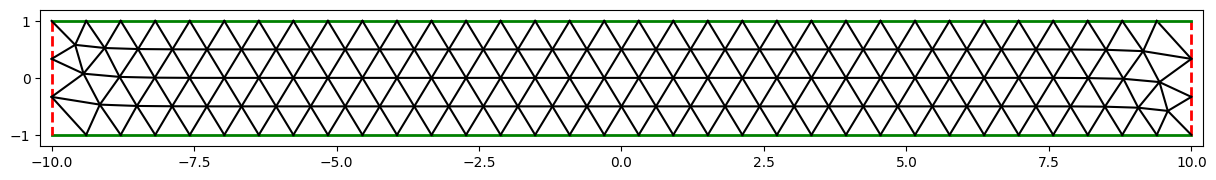

In [4]:
checkLabels(Edges)

and the orientation of the normals...

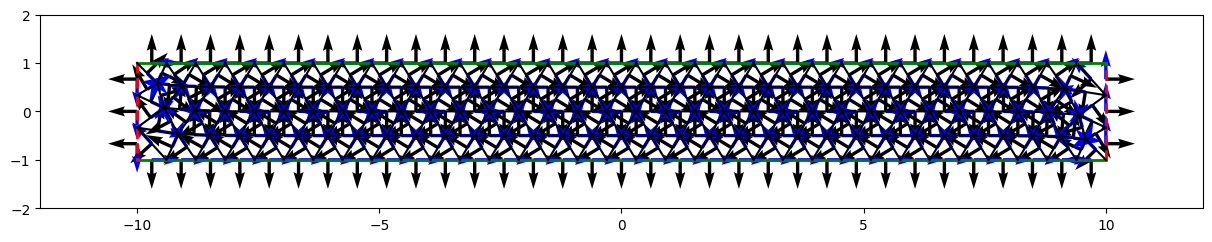

In [5]:
checkNormals(Edges)

and the definition of the "plus" and "minus" quantities...

In [6]:
  # checkPlusMinus(Edges, Baricenters) 

In [7]:
kappa_e = 8.
kappa_i = 5.


In [8]:
# #optimal angle for mode "t" : th = arcsin( lambda /  (2H)) 
# dth = np.arcsin( t*np.pi / (kappa_e*H))
# # optimal number of waves for mode "t":
# Nth = int(2*np.pi / dth)
# Nth 

In [9]:
Nth = 1
Np = 15

V = TrefftzSpace(Omega, Nth, {"Omega_i" : kappa_i , "Omega_e" : kappa_e}, 0.0)


In [10]:


a, b, d1, d2 = 0.5, 0.5, 0.5, 0.

A = AssembleMatrix(V, Edges, kappa_e, H, a, b, d1, d2, Np=Np)


In [11]:
#Ncond = np.linalg.cond(A)
Ncond = -1

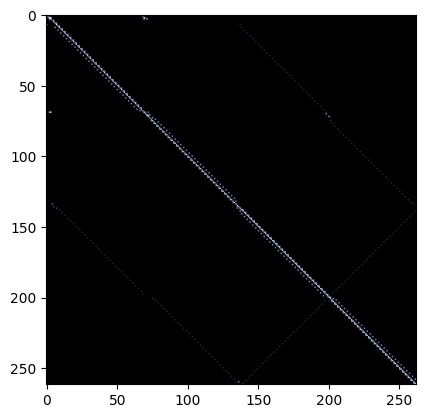

In [12]:
plt.imshow(np.abs(A), cmap='bone')

In [13]:

t = 1
B = AssembleRHS(V, Edges, kappa_e, H, d2, t=t)

In [14]:
DOFs = np.linalg.solve(A,B)
f = TrefftzFunction(V,DOFs)

In [15]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(-H,H,Ny)
X, Y = np.meshgrid(x,y)

Z =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


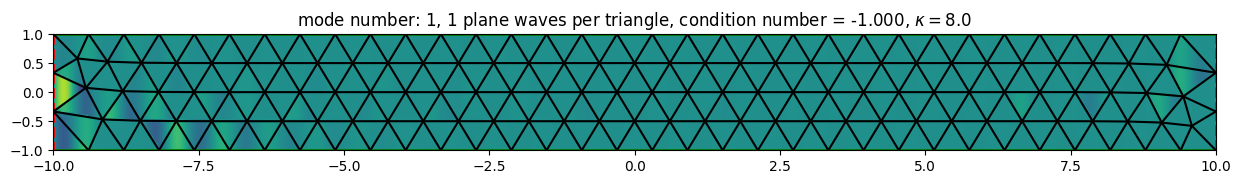

In [16]:
_, ax = plt.subplots( figsize=(15,3))

# ax.imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H])
ax.imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H], vmin=-1, vmax=1)

checkLabels(Edges, ax)
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([-H,H])
plt.title(f'mode number: {t}, {Nth} plane waves per triangle, condition number = {Ncond: .3f}, $\\kappa={kappa_e:.1f}$')

save = False
if save:
    plt.savefig(f'test_{t}_{Nth}_d2.png')

In [17]:
len(DOFs)

262

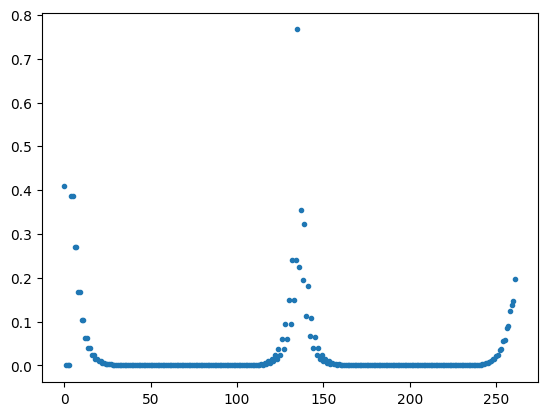

In [18]:
plt.plot(np.abs(DOFs),'.')
#print(DOFs)

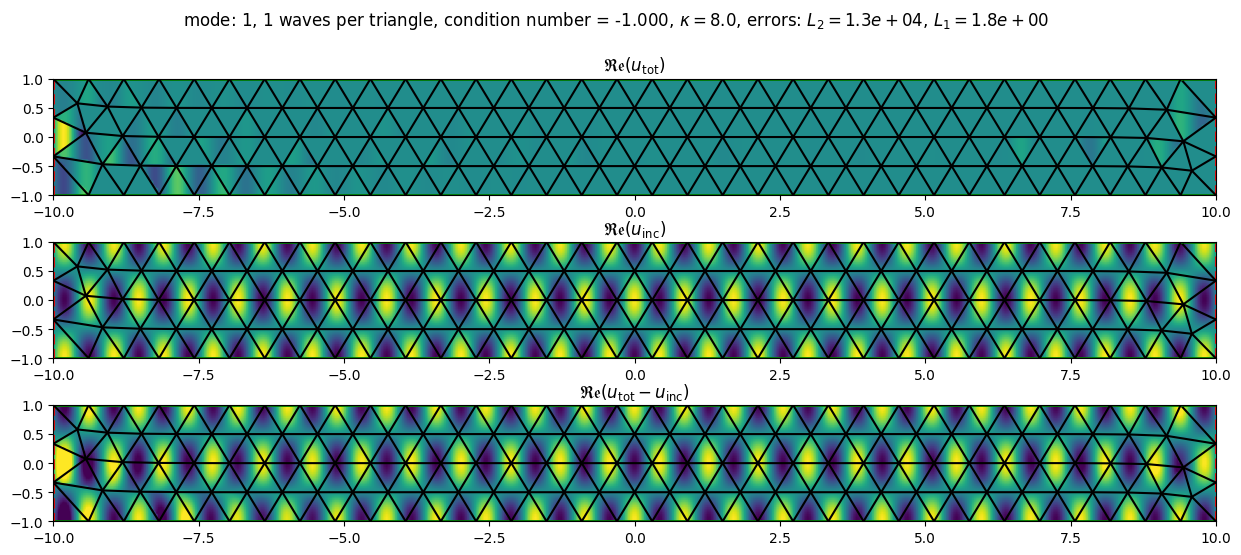

In [19]:
fig, ax = plt.subplots( nrows = 3, figsize=(15,6))

ax[0].imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H])

checkLabels(Edges, ax[0])
ax[0].axis('square')
ax[0].set_xlim([-R,R])
ax[0].set_ylim([-H,H])

Z_inc = np.exp(1j*np.sqrt(kappa_e**2 - (t*np.pi/H)**2)*X)*np.cos(t*np.pi*Y/H)

L2_err = np.sum(np.abs(Z - Z_inc)**2)
L1_err = np.max(np.abs(Z - Z_inc))


ax[1].imshow(np.real(Z_inc), origin="lower", extent=[-R,R,-H,H])

checkLabels(Edges, ax[1])
ax[1].axis('square')
ax[1].set_xlim([-R,R])
ax[1].set_ylim([-H,H])



ax[2].imshow(np.real(Z-Z_inc), origin="lower", extent=[-R,R,-H,H], vmin=-1, vmax=1)

checkLabels(Edges, ax[2])
ax[2].axis('square')
ax[2].set_xlim([-R,R])
ax[2].set_ylim([-H,H])

fig.suptitle(f'mode: {t}, {Nth} waves per triangle, condition number = {Ncond: .3f}, $\\kappa={kappa_e:.1f}$, errors: $L_2={L2_err:.1e}$, $L_1={L1_err:.1e}$')
ax[0].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
ax[1].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{inc}\\right)$')
ax[2].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}-u_\\mathrm{inc}\\right)$')

save = False
if save:
    plt.savefig(f'both_{t}_{Nth}_d2.png')

(-1.0, 1.0)

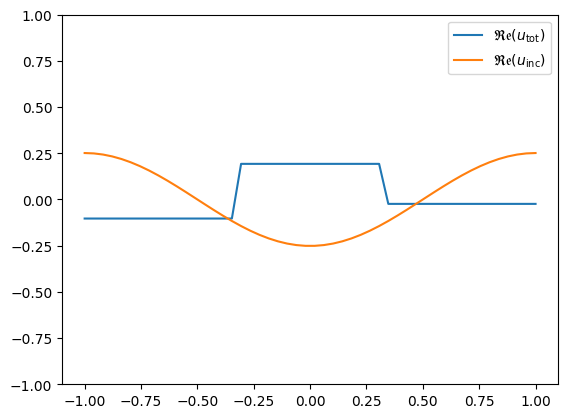

In [20]:
plt.plot(y,np.real(Z[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
plt.plot(y,np.real(Z_inc[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{inc}\\right)$')
plt.legend()
plt.ylim([-1,1])

In [21]:
def NtD(y, df_dy, k, H, M):

    dfn = np.zeros(M, dtype=np.complex128)
    dfn[0] = Int( df_dy*1/sqrt(2*H), y )
    for n in range(1,M):
        dfn[n] = Int( df_dy*cos(n*pi*y/H)/sqrt(H), y )
    
    f_y = 1/(1j*k)*dfn[0]/sqrt(2*H)*np.ones_like(y) + sum([ 1/(1j*sqrt(complex(k**2 - (n*pi/H)**2)))*dfn[n]*cos(n*pi*y/H)/sqrt(H) for n in range(1,M)])
    return f_y

def Sigma_numeric(P, Q, N, d_m, d_n, k, H, Np, Ny=100):
    y = np.linspace(P[1], Q[1], Ny)
    x = np.linspace(P[0], Q[0], Ny)
    r = np.array( [x,y] ).transpose()

    gradu = 1j*k*dot(d_n,N)*exp(1j*k*dot(r,d_m))
    gradv = 1j*k*dot(d_m,N)*exp(1j*k*dot(r,d_m))
    v = exp(1j*k*dot(r,d_m))
    return Int( NtD(y,gradu,k,H,Np)*conj(gradv) - gradu*conj(v), y)

In [137]:
E = Edges[1]
E

Edgetype: EdgeType.SIGMA_L
        (Px, Py): (-10.0, -0.3333333333333339) 
        (Qx, Qy): (-10.0, -1.0)

In [142]:
phi = TestFunction(kappa_e, np.array([1,1])/np.sqrt(2))
psi = TestFunction(kappa_e, np.array([1,-1])/np.sqrt(2))

Np = 15
S = Sigma_broken(phi,psi,E, kappa_e,H,d_2=0., Np=Np)
S_num = Sigma_numeric(E.P, E.Q, E.N, psi.d, phi.d, kappa_e, H, Np=Np, Ny=1000)

In [143]:
S

(0.0029867807586744233+1.9500723864297427j)

In [144]:
S_num

(-0.2882197057623945-5.215394320268231j)

In [135]:
E.N

array([-1.,  0.])

In [119]:
kappa_e

8.0

In [141]:
H

1.0